# Financial News Headline Sentiment Classifier

Cody Lange
August 8th, 2023

**Motivation**
Market sentiment derived from news articles is one factor that can influence trading and investment decisions. By understanding the sentiment of financial news headlines, investors, traders, and financial institutions have another tool that they can use to make more informed decisions, assess risks, and potentially even design algorithmic trading strategies. This notebook demonstrates the process of training a BERT (Bidirectional Encoder Representations from Transformers) model on the financial_phrasebank dataset to classify Yahoo Finance headlines into three sentiment categories: positive, neutral, and negative. While this exercise uses financial headlines as an input, the underlying techniques used in this notebook can be transferred to simmilar text classification tasks.
The methods outlined in this notebook also serve as a less-complicated, indirect sample for my actual data science work making a similar transformer model for multilabel text classification.

**Data Source**
The financial_phrasebank dataset is a collection of financial news headlines for companies listed in OMX Helsinki, each labeled with a sentiment score of 2 for positive, 1 for neutral, or 0 for negative. Labels were decided upon by a group of 13 annotators at the  Aalto University School of Business in which 75% of the judges agree.

In [1]:
import pandas as pd
import pyodbc as pb
from tqdm.notebook import tqdm

# Show all dataframe columns
pd.set_option('display.max_columns', None)

In [2]:
from datasets import load_dataset, concatenate_datasets

# Load the datasets into a pandas dataframe
headlines = pd.DataFrame( load_dataset("financial_phrasebank", "sentences_75agree")["train"] )

Found cached dataset financial_phrasebank (C:/Users/langecod/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
headlines.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,With the new production plant the company woul...,2
2,"For the last quarter of 2010 , Componenta 's n...",2
3,"In the third quarter of 2010 , net sales incre...",2
4,Operating profit rose to EUR 13.1 mn from EUR ...,2


In [4]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3453 non-null   object
 1   label     3453 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.1+ KB


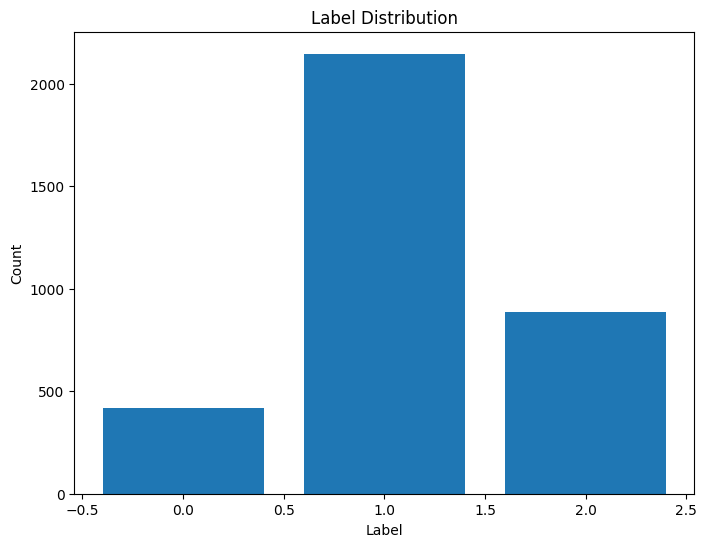

In [5]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = headlines['label'].value_counts()

# Create a bar plot of the label distribution
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

# Cleaning?

Less is more when training a transformer model, such as RoBERTa, for text classification. The basic concept behind transformers is to learn optimal representations of language by understanding the contexts, nuances, and intricacies present in the text. This is achieved by representing text as a sequence of tokens and using an attention mechanism to learn the effect of each token on the others in the sequence. Training the model on unprocessed text preserves the semantic richness of the language, which would otherwise be parsed out through the removal of special characters and stop words, stemming, lemmatization, etc. While text cleaning is warranted for simpler models that benefit from uniformity, dimensionality reduction, and noise removal, (see Tf-IDF, count vectorization, etc.) opting out of text processing is advantageous here since the news headlines are short enough to meet the 512-token input limit

# Check: Do our Inputs Meet the 512 Token Limit?

In [6]:
# What are the indices of the 10 longest notes?
# These are the longest character lengths, not necessarily the longest token lengths
ten_longest_inputs_idx = headlines['sentence'].apply(lambda x: len(x)).sort_values(ascending=False).index[:50]

ten_longest_inputs_idx

Int64Index([1222, 1654,  729, 2139, 2996,  319, 2708, 3280, 2196, 1903,  975,
            2195, 2733, 1871, 1528, 1699, 3201,  959,  958,  850,   48, 1525,
            2119, 1653, 1242,  677,  621,  722,  359, 1232, 1083,  330, 2056,
            2130,   59,  905, 1077, 3222, 1828, 1876, 1385, 1387, 3202, 1633,
            2762,  114, 1199, 3197,   60, 3436],
           dtype='int64')

In [7]:
from transformers import AutoTokenizer
import heapq

# Let's check how many tokens these are... Might not need all 512 tokens
ten_longest_inputs = headlines['sentence'].iloc[ten_longest_inputs_idx].values

print('Loading tokenizer')
tokenizer = AutoTokenizer.from_pretrained("soleimanian/financial-roberta-large-sentiment")

token_lengths = []
max_tokens = 0
for input in ten_longest_inputs:
    encodings = tokenizer(input,
                            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                            max_length=512,
                            truncation=True,
                            padding='do_not_pad')
    input_ids = encodings.input_ids
    max_tokens = max(max_tokens, len(input_ids))

print(f'The longest sequence is {max_tokens} tokens')

Loading tokenizer
The longest sequence is 133 tokens


# Labels

In [8]:
label2id = {'Positive': 2,
            'Neutral': 1,
            'Negative': 0
            }
id2label = {0: 'Negative',
            1:'Neutral',
            2: 'Positive'}
    
label2id

{'Positive': 2, 'Neutral': 1, 'Negative': 0}

In [9]:
id2label

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [ ]:
headlines.head()

# Make Train/Test Splits

Use Stratified Shuffle Split to ensure equal class distribution among splits

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

X = headlines[['sentence']].values
y= headlines.label.values

# Define the split sizes
split_sizes = [0.8, 0.1, 0.1]

# Define the splitter with 2 splits
splitter = StratifiedShuffleSplit(n_splits=2, test_size=split_sizes[-1], random_state=42)

# Split the data into a train-dev set and a test set
train_dev_indices, test_indices = next(splitter.split(X, y))

# Get the train-dev data and the test data
X_train_dev, y_train_dev = X[train_dev_indices], y[train_dev_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Define the sizes of the train and dev sets
train_size = int(split_sizes[0] * len(X_train_dev))
dev_size = int(split_sizes[1] * len(X))

# Split the train-dev set into a train set and a dev set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=dev_size, random_state=42)
train_indices, dev_indices = next(splitter.split(X_train_dev, y_train_dev))

# Get the train data and the dev data
X_train, y_train = X_train_dev[train_indices], y_train_dev[train_indices]
X_dev, y_dev = X_train_dev[dev_indices], y_train_dev[dev_indices]

In [ ]:
X_train

In [ ]:
X_train.shape

In [ ]:
X_dev.shape

In [ ]:
X_test.shape

In [ ]:
# Get the lists of sentences and their labels.
train_sentences = [narr[0] for narr in X_train] 
train_labels = y_train
dev_sentences = [narr[0] for narr in X_dev]
dev_labels = y_dev
test_sentences = [narr[0] for narr in X_test]
test_labels = y_test

# Tokenization

Tokenization abstracts the news headlines into a structured form that RoBERTa can interpret. This involves breaking the text into smaller units, inserting [CLS] and [SEP] tokens to mark the beginning and end of sentences, padding shorter inputs with [PAD] tokens to a uniform length (133 length as discovered earlier), and truncating longer ones. Attention masks are also created to distinguish between actual inputs and padding. The breakdown and structuring of text in this manner enable the model to effectively understand unseen words, allocate attention appropriately, and capture the contextual relationships within the text, allowing it to make more accurate predictions.

In [ ]:
from datasets import Dataset

def get_encodings(sentences):

    sentence_dataset = Dataset.from_dict({'sentences':sentences } )
    encodings = sentence_dataset.map(lambda x: tokenizer(
                                                                x['sentences'], 
                                                                add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                                                                max_length=max_tokens, # Replace this part with max_tokens for BigBird
                                                                truncation=True,
                                                                padding='max_length',
                                                                ),
                                            batched=True,
                                            )

    return encodings 

In [ ]:
train_encodings = get_encodings(train_sentences)

In [ ]:
train_inputs = train_encodings[:]['input_ids']
train_attention = train_encodings[:]['attention_mask']

In [ ]:
dev_encodings = get_encodings(dev_sentences)

In [ ]:
dev_inputs = dev_encodings[:]['input_ids']
dev_attention = dev_encodings[:]['attention_mask']

In [ ]:
test_encodings = get_encodings(test_sentences)

In [ ]:
test_inputs = test_encodings[:]['input_ids']
test_attention = test_encodings[:]['attention_mask']

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model

import torch

#Inputs
train_inputs = torch.tensor(train_inputs, dtype=torch.int32)
dev_inputs = torch.tensor(dev_inputs, dtype=torch.int32)
test_inputs = torch.tensor(test_inputs, dtype=torch.int32)

#Labels
train_labels = torch.tensor(train_labels, dtype=torch.long)
dev_labels = torch.tensor(dev_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

#Masks
train_masks = torch.tensor(train_attention, dtype=torch.int32)
dev_masks = torch.tensor(dev_attention, dtype=torch.int32)
test_masks = torch.tensor(test_attention, dtype=torch.int32)

In [ ]:
from datasets import Dataset 

# Load the input ids, masks, etc. into separate datasets

train_dataset = Dataset.from_dict({'input_ids':train_inputs,
                                    'attention_mask': train_masks,
                                    'labels': train_labels})

dev_dataset =  Dataset.from_dict({'input_ids': dev_inputs,
                                 'attention_mask': dev_masks,
                                 'labels':dev_labels})

test_dataset =  Dataset.from_dict({'input_ids':test_inputs,
                                    'attention_mask':test_masks,
                                    'labels':test_labels})

# RoBERTa (Robustly Optimized BERT Approach)

RoBERTa was chosen for this project to harness its advanced contextual understanding and exceptional performance in text classification tasks. RoBERTa is a high-performing transformer model developed by Facebook AI, excelling in numerous NLP tasks by leveraging attention mechanisms to understand the intricacies of language. Attention mechanisms enable the model to process and interpret the contextual relations and nuances between different parts of the input text. RoBERTa surpasses its predecessor, BERT, by using refined training techniques, larger datasets, and architectural improvements, which include the elimination of BERT's Next Sentence Prediction objective and dynamic adjustment of input token masking. This optimized training and enhanced contextual understanding make RoBERTa an excellent choice for this text classsification task. 

## Leveraging a Pre-Trained Model for Transfer Learning?

Financial RoBERTa provides an opportunity for transfer learning, as it already acquired acquired an understanding of financial texts through fine-tuning on extensive financial documents like 10Ks and earnings call transcripts (important to note not the dataset used for this task). Using this specialized, pre-trained model facilitates more powerful predictions by effectively increasing the knowledge base of the text documents the model has to learn a language representation from.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModel, AutoModelForSequenceClassification, AutoModelForCausalLM

model = AutoModelForSequenceClassification.from_pretrained(
    "soleimanian/financial-roberta-large-sentiment", 
    num_labels = len(label2id),
    problem_type = "single_label_classification",
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    id2label=id2label,
    label2id=label2id,
    )

# Tell pytorch to run this model on the GPU.
model.to('cuda')

In [ ]:
print(model.get_memory_footprint())

# Evaluation Metrics: Accuracy, Macro/Weighted F1, Precision, Recall

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Function to calculate the accuracy and other metrics of our predictions vs labels
def compute_metrics_multiclass(eval_pred):

    # Labels give the ground truth for each *sentence* (num_classes, 1)
    # Preds give the unnormalized probabilities for each class in a sentence (num_sentences, num_classes)
    preds, labels = eval_pred

    preds_flat = np.argmax(preds, axis=1).flatten() # Get the index of the most probable classes (Already mapped index=class) and flatten to give one pred/sentence
    labels_flat = labels.flatten()

    print("Predicted Sample: ")
    print(preds_flat[:10])
    print("Actual Sample: ")
    print(labels_flat[:10])

    # Convert logits to float32 before applying softmax (flexibility for fp16 training)
    preds_float32 = torch.tensor(preds, dtype=torch.float32)

    # Convert logits to probabilities 
    preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)

    # Calculate the accuracy of the top 1 predictions
    acc = accuracy_score(labels_flat, preds_flat)

    # Calculate precision, recall, and F1 score
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels_flat, preds_flat, average='weighted')
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels_flat, preds_flat, average='macro')

    return {
        'accuracy': acc,
        'precision_weighted': precision_weighted,
        'precision_macro': precision_macro,
        'recall_weighted': recall_weighted,
        'recall_macro': recall_macro,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }


# Training Arguments

In response to past experiences with extensive memory usage and slow computational speed during model training, adjustments were made to optimize resource efficiency. Mixed precision training (fp16) was employed, reducing memory requirements and accelerating computations. Concurrently, the 8BitAdam optimizer was used to compress model weights from 32 bits to 8 bits, conserving memory while preserving performance. Additionally, early stopping was implemented to prevent unnecessary computations and overfitting, contributing to a more efficient and dependable training process, essential for managing large datasets and advanced deep learning models.

In [ ]:
import torch
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import multiprocessing as mp
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import bitsandbytes as bnb
from bitsandbytes.optim import AdamW8bit
from torch import nn
from transformers.trainer_pt_utils import get_parameter_names


batch_size = 64

# Set threads==num cores on the machine
torch.set_num_threads(mp.cpu_count())

training_args = TrainingArguments(
    output_dir="Sentiment_Analysis_1stPass",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    do_eval=True,
    do_predict=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,        # Leave extra epochs in case learning brakes out of unoptimal convergence
    gradient_accumulation_steps=1,
    gradient_checkpointing=False,
    learning_rate=1e-6,
    warmup_ratio = 0.4,  
    fp16=True,  # gradients are computed in half precision & converted back to 32bit for the optimization step
    disable_tqdm=False,
    dataloader_pin_memory=True,
    logging_dir='./logs',
    save_total_limit=1,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # Want smaller loss
    load_best_model_at_end=True,
    resume_from_checkpoint=False,
)

'''
If you want to run a larger model and/or use a larger batch size, uncomment the bel
'''
decay_parameters = get_parameter_names(model, [nn.LayerNorm])
decay_parameters = [
    name for name in decay_parameters if "bias" not in name]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if n in decay_parameters],
        "weight_decay": training_args.weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
        "weight_decay": 0.00,
    },
]

optimizer_kwargs = {
    "betas": (training_args.adam_beta1, training_args.adam_beta2),
    "eps": training_args.adam_epsilon,
}
optimizer_kwargs["lr"] = training_args.learning_rate
adam_bnb_optim = bnb.optim.Adam8bit(
    optimizer_grouped_parameters,
    betas=(training_args.adam_beta1, training_args.adam_beta2),
    eps=training_args.adam_epsilon,
    lr=training_args.learning_rate,
)

In [ ]:
trainer = Trainer(
    model,
    training_args,
    optimizers=(adam_bnb_optim, None), #Uncomment accordinggly if you want 8 bit adam
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics_multiclass,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.01)],
    tokenizer=tokenizer)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary())

In [ ]:
trainer.train()

In [ ]:
test_results = trainer.predict(test_dataset)

In [ ]:
print(test_results)

In [ ]:
model.save_pretrained(r'Sentiment_Roberta')

In [ ]:
tokenizer.save_pretrained(r'Sentiment_Roberta')